# 3D Volume to Volume GAN

In [1]:
%matplotlib inline

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.transform import resize
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../scripts')

import pix3pix as p3p
import helper as hp
import data_loader3D as dl
import deconvolution as deconv

sys.path.insert(0, '../scripts/NanoImagingPack')
from microscopy import PSF3D

Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings("ignore")

## look for the data

In [5]:
dataset_name = 'NESb'
path = glob('../data/3D/{0}/*'.format(dataset_name))
path = [item for item in path if not item.endswith('.txt')]

dl.print_volume_dimension(path)

dimensions of volumes:
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)
(9, 1024, 1024)


## create TFRecord file

In [6]:
vol_dim = (128, 128, 9)

data_loader = dl.DataLoader3D(dataset_name='NESb', vol_resize=vol_dim)
filename = '../data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

## test the 3D psf for a random volume

In [53]:
path = '../data/3D/NESb/NESb_C2_TP1.tiff'
vol = io.imread(path)
vol = hp.swapAxes(vol, swap=True)
vol = resize(image=vol, output_shape=vol_dim)
print('image after resize in x/y dimension:', vol.shape)

# compute OTF
start_otf = time.time()
otf = PSF3D(im=vol.shape, ret_val = 'OTF')
end_otf = time.time()

# perform convolution on stack with computed otf (with numpy)
start_conv_np = time.time()
vol_otf = deconv.conv3d_fft(vol, otf)
end_conv_np = time.time()

# perform convolution on stack with computed otf (with tensorflow)
# start_conv_tf = time.time()
# vol_otf_tf = deconv.conv3d_fft_tf(vol, otf)
# end_conv_tf = time.time()

# select a random stacks
i = np.random.randint(low=0, high=vol.shape[2], size=1)[0]
print('stack number:\t\t\t', i+1,'/',vol.shape[2])
img = vol[:,:,i]
img_otf = vol_otf[:,:,i]
# img_otf_tf = vol_otf_tf[:,:,i]

print('Time for compute OTF:\t\t', end_otf - start_otf, 's')
print('Time for convolve with numpy:\t', end_conv_np - start_conv_np, 's')
# print('Time for convolve with tensorflow:\t', end_conv_tf - start_conv_tf, 's')

image after resize in x/y dimension: (128, 128, 9)
stack number:			 7 / 9
Time for compute OTF:		 0.04687142372131348 s
Time for convolve with numpy:	 0.031252384185791016 s


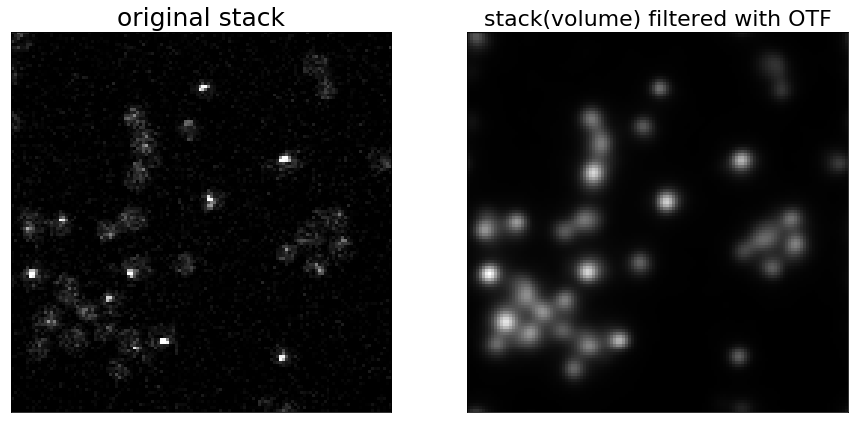

In [54]:
f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25)
plt.subplot(122); plt.imshow(img_otf, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
# plt.subplot(133); plt.imshow(img_otf_tf, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()

## initialize the volume to volume GAN

In [132]:
volume_resize = vol_dim
directory_name = dataset_name #'NESb'

gan = p3p.Pix3Pix(vol_resize=volume_resize, d_name=directory_name,
                  stack_manipulation=p3p.MANIPULATION.SPATIAL_DOWN)
                  
                 #.SPATIAL_MIN
                 #.SPATIAL_DOWN                  
                 #.SPATIAL_UP
                 #.FREQUENCY_UP
                 #.FREQUENCY_DOWN

discriminator-model in/output:	 (?, 128, 128, 8, 1) (?, 128, 128, 8, 1) 
				 (?, 16, 16, 1, 1)
generator-model input:		 (?, 128, 128, 8, 1)
downsampling:			 (?, 64, 64, 4, 64)
downsampling:			 (?, 32, 32, 2, 128)
downsampling:			 (?, 16, 16, 1, 256)
downsampling:			 (?, 8, 8, 1, 512)
downsampling:			 (?, 4, 4, 1, 512)
upsampling:			 (?, 8, 8, 1, 512)
upsampling:			 (?, 16, 16, 1, 256)
upsampling:			 (?, 32, 32, 2, 128)
upsampling:			 (?, 64, 64, 4, 64)
generator-model output:		 (?, 128, 128, 8, 1) (?, 128, 128, 8, 1)
finish Pix3Pix __init__


## train volume to volume GAN

In [133]:
epochs = 1

gan.train(epochs=epochs, add_noise=True)

ResourceExhaustedError: OOM when allocating tensor with shape[6,128,129,129,9] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: generator_3/conv3d_56/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](generator_3/up_sampling3d_20/concat_2, conv3d_56/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss_7/generator_loss/Mean_3/_1235 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9600_loss_7/generator_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'generator_3/conv3d_56/convolution', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-132-9e7d80dbb45f>", line 5, in <module>
    stack_manipulation=p3p.MANIPULATION.SPATIAL_DOWN)
  File "../scripts\pix3pix.py", line 83, in __init__
    fake_A = self.generator(vol_B)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\engine\topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\layers\convolutional.py", line 176, in call
    dilation_rate=self.dilation_rate)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\backend\tensorflow_backend.py", line 3567, in conv3d
    data_format=tf_data_format)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 782, in convolution
    return op(input, filter)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 870, in __call__
    return self.conv_op(inp, filter)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 522, in __call__
    return self.call(inp, filter)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 206, in __call__
    name=self.name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1482, in conv3d
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[6,128,129,129,9] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: generator_3/conv3d_56/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](generator_3/up_sampling3d_20/concat_2, conv3d_56/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss_7/generator_loss/Mean_3/_1235 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9600_loss_7/generator_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



## release GPU memory

In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

In [ ]:
delete_model_memory = False

if delete_model_memory:
    try:
        del gan, discriminator, combined, generator 
    except:
        print('models not available')

## plot random volume with 3 random stacks of GAN

plotted volume: images/NESb\NESb_2018-07-19_17_23_06\0_0.png


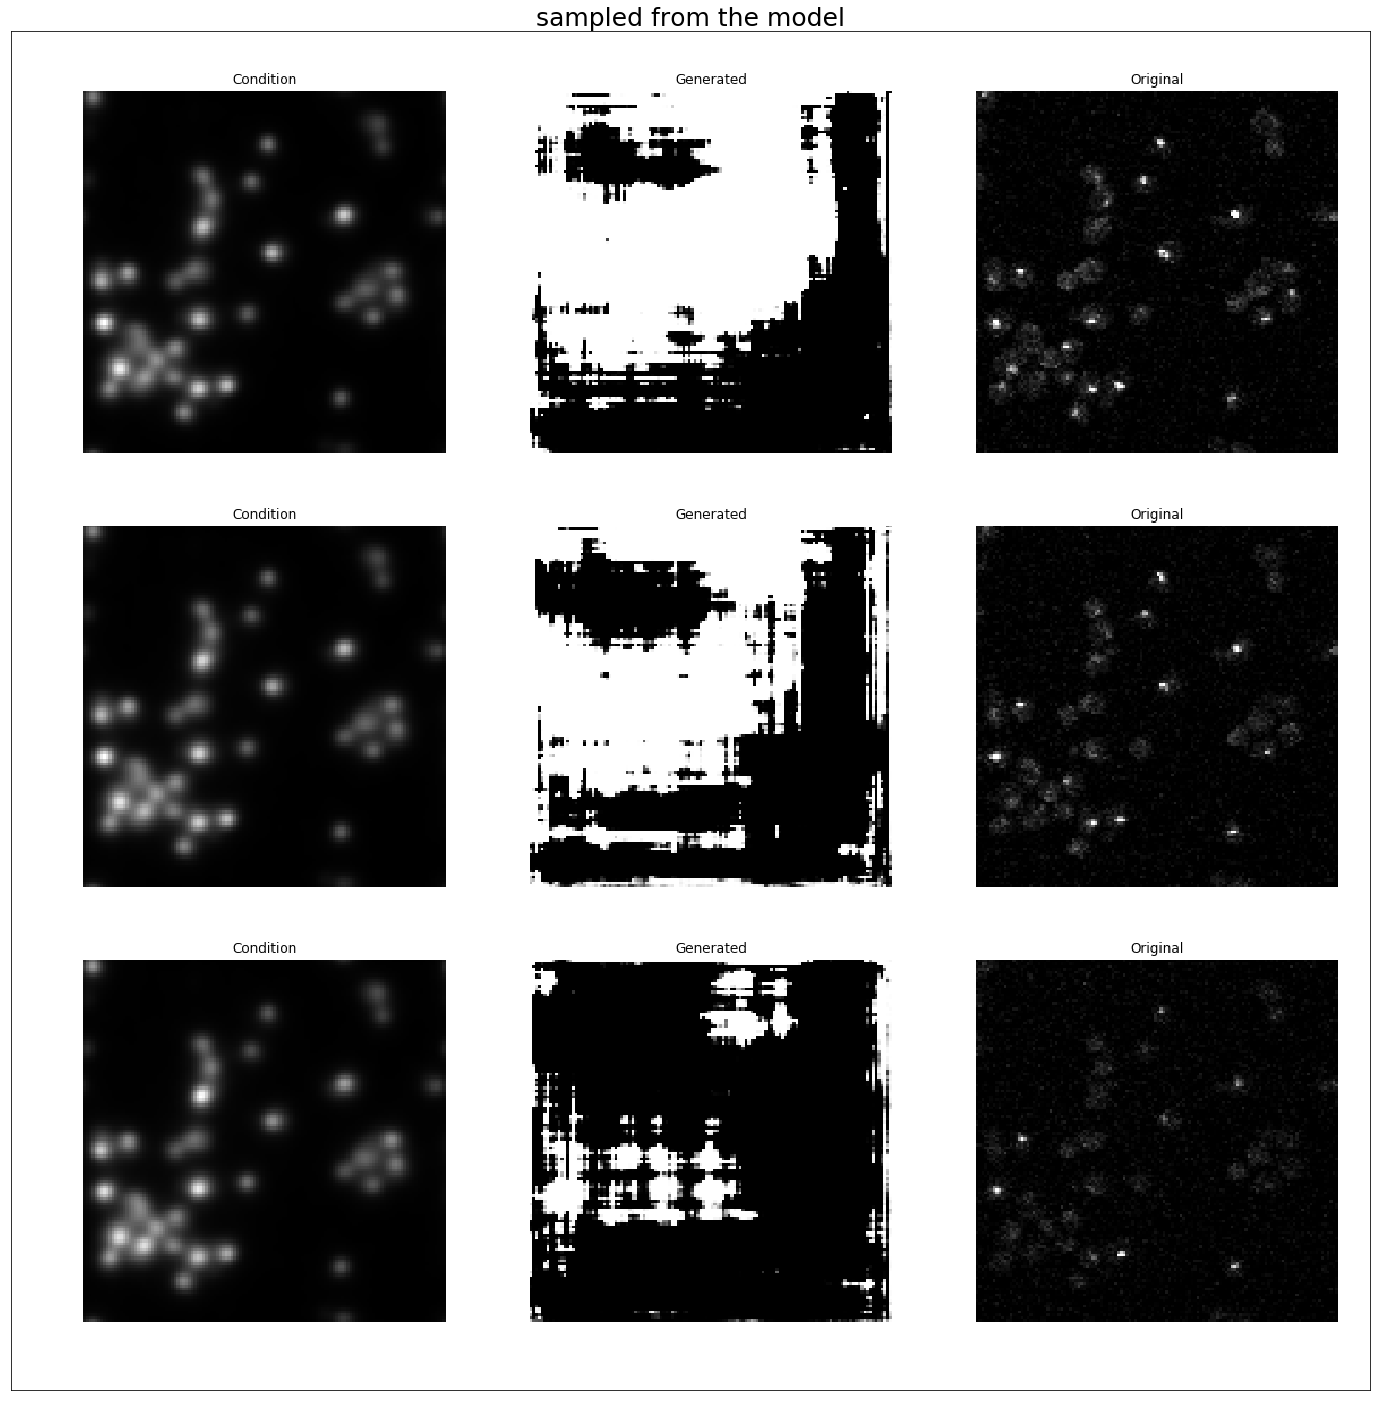

In [19]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
selected_folder = model_vols[-1]+'/*'

volumes = glob(selected_folder)
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)
cut = 120; ed = vol_plot.shape[0]
vol_plot = vol_plot[cut:ed-cut, cut:ed-cut , :]

print('plotted volume:', volumes)
f = plt.figure(figsize=(25,25))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

## save models, gradients and parameters

In [20]:
save_models = False

if save_models:
    hp.model_saver(model_instance=gan.discriminator, model_name='disc_10%')
    hp.model_saver(model_instance=gan.generator, model_name='gene_10%')
    hp.model_saver(model_instance=gan.combined, model_name='combined_10%')

## create deconvolution model

tf.fft_shift needs even number of dims, so eventually cut an array (then create new otf)

In [21]:
print(vol.shape, otf.shape)
vol_new = vol[:,:,:8]
otf_new = PSF3D(im=vol_new.shape, ret_val = 'OTF')
print(vol_new.shape, otf_new.shape)

(128, 128, 9) (128, 128, 9)
(128, 128, 8) (128, 128, 8)


In [131]:
# otf = PSF3D(im=vol.shape, ret_val = 'OTF')

deconvolution = deconv.Deconvolution_3D(img=vol_new, gan=gan_test, 
                                        psf=otf_new, simulation=False)

FailedPreconditionError: Attempting to use uninitialized value conv3d_33/kernel
	 [[Node: conv3d_33/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@conv3d_33/kernel"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv3d_33/kernel)]]
	 [[Node: conv3d_42/Tanh/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1266_conv3d_42/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv3d_33/kernel/read', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-91978fd974ea>", line 8, in <module>
    stack_manipulation=p3p.MANIPULATION.SPATIAL_DOWN)
  File "../scripts\pix3pix.py", line 76, in __init__
    self.generator = self.build_generator()
  File "../scripts\pix3pix.py", line 155, in build_generator
    d1 = conv3d(d0, self.gf, bn=False); c += 1
  File "../scripts\pix3pix.py", line 123, in conv3d
    d = Conv3D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\engine\topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\layers\convolutional.py", line 138, in build
    constraint=self.kernel_constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\engine\topology.py", line 416, in add_weight
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\backend\tensorflow_backend.py", line 396, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 235, in __init__
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 391, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 142, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3658, in identity
    "Identity", input=input, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv3d_33/kernel
	 [[Node: conv3d_33/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@conv3d_33/kernel"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv3d_33/kernel)]]
	 [[Node: conv3d_42/Tanh/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1266_conv3d_42/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


## perform deconvolution model

In [99]:
deconvolution.optimize()

#  TEST

In [112]:
gan_test.discriminator

In [113]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12168730087838335897, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6681632440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3932406532661860362
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(a))
        
# I believe that you need to set CUDA_VISIBLE_DEVICES=1. Or which ever GPU you want to use. 
#If you make only one GPU visible, you will refer to it as /gpu:0 regardless of what you set the environment variable to.
#More info on that environment variable: http://www.acceleware.com/blog/cudavisibledevices-masking-gpus

# https://stackoverflow.com/questions/40069883/how-to-set-specific-gpu-in-tensorflow

# if gpu > -1:
#     device = '/gpu:{}'.format(gpu)
# else:
#     device = '/cpu:0'

# with tf.device(device):
#     print('test')

In [ ]:
saver = tf.train.Saver(restore_sequentially=True)
saver_def = saver.as_saver_def()

In [ ]:
a = np.arange(9).reshape((3, 3))
b = np.arange(9)- 4 
b = b.reshape((3, 3))
mean=0; var = 0.1; sigma = var**0.5
c = deconv.add_gaussian(a) #a + np.random.normal(mean, sigma, a.shape)
print(a,'\n\n', b, '\n\n', c)

In [ ]:
print(np.linalg.norm(a-b, ord='fro'))

# frobenius = lambda matrix: np.sqrt(np.sum(matrix ** 2))
frobenius = lambda matrix: np.sqrt(np.sum(np.square(matrix)))
frobenius(a - b)

In [ ]:
from keras import losses

losses.kullback_leibler_divergence
losses.mean_squared_error
losses.mean_squared_logarithmic_error
losses.sparse_categorical_crossentropy

tf.image.ResizeMethod.BILINEAR

In [ ]:
# a = tf.constant(vol_plot)
# b = deconvolution.total_variation(a)

vol_tf = tf.constant(vol_new)
otf_tf = tf.constant(otf_new)

conv = deconv.conv3d_fft_tf(vol=vol_tf, otf=otf_tf)

with tf.Session() as sess:
    vol_conv_tf = sess.run(conv)
    i = np.random.randint(low=0, high=vol_conv_tf.shape[2], size=1)[0]
    print('stack number:\t\t\t', i+1,'/',vol_conv_tf.shape[2])
    img_conv_tf = vol[:,:,i]
        
    plt.imshow(img_conv_tf, cmap='gray')
       
    
# 296215300